In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')


# Strategy: MA crossovers:
# Bullish crossover occurs when the short-term SMA crosses above the long-term SMA. (Buy)
# Bearish crossover occurs when the short-term SMA crosses below the long-term SMA. (Sell)
# I want to try to figure out the best points of entry and exit based on total return.
# Experiment with 2 ML classifiers (Decision Tree & RF) as well as the baseline EMA and SMA
# 'Backtest' with PnL


# Load the SPY.csv dataset
df = pd.read_csv("SPY_Daily.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)


# Lets plot the SPY close to get an idea of what it visually looks like. 

df['Date'] = pd.to_datetime(df['DateTime'])

# Step 3: Set 'Date' column as the index
df.set_index('Date', inplace=True)
df


,DateTime,Open,High,Low,Close
Date,,,,,
2018-06-18,2018-06-18,275.49,276.70,274.95,276.56
2018-06-19,2018-06-19,274.00,275.75,273.53,275.50
2018-06-20,2018-06-20,276.27,276.72,275.59,275.97
2018-06-21,2018-06-21,275.96,275.98,273.68,274.24
2018-06-22,2018-06-22,275.66,275.79,274.49,274.74
...,...,...,...,...,...
2023-06-12,2023-06-12,430.92,433.88,430.17,433.80
2023-06-13,2023-06-13,435.32,437.33,434.63,436.66
2023-06-14,2023-06-14,437.01,439.07,433.59,437.18


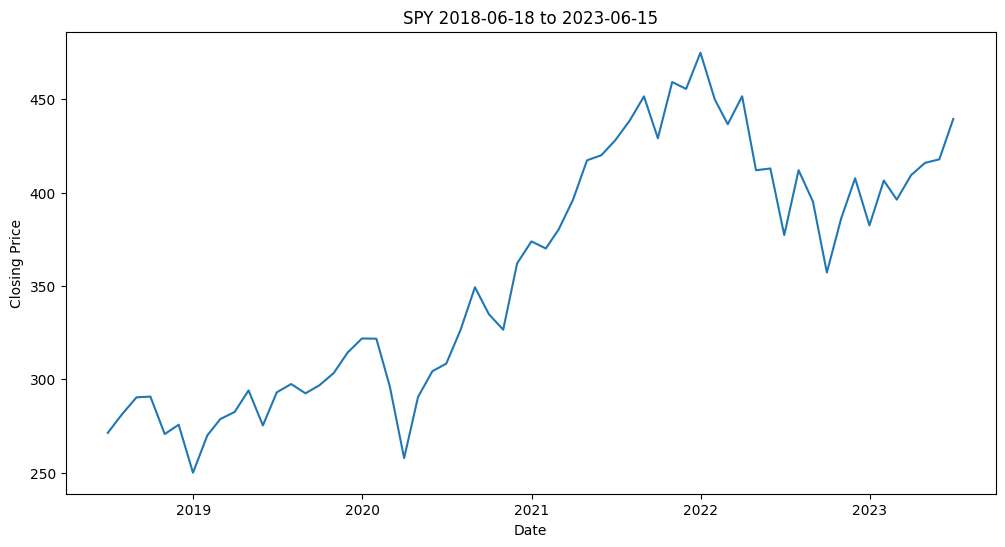

In [78]:
# Visualize SPY Data 
monthly_df = df.resample('M').last()

plt.figure(figsize=(12, 6))
plt.plot(monthly_df.index, monthly_df['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('SPY 2018-06-18 to 2023-06-15')
plt.show()


In [79]:
#Establish EMA/SMA strategies


#K eeping windows simple for now. Can obviously experiment with different window sizes and optimize. 
short_window = 10
long_window = 30

# Calculate the short-window simple moving average
df['short_sma'] = df['Close'].rolling(window=short_window).mean()
df['long_sma'] = df['Close'].rolling(window=long_window).mean()

# Calculate the short-window exponential moving average
df['short_ema'] = df['Close'].ewm(span=short_window, adjust=False).mean()
df['long_ema'] = df['Close'].ewm(span=long_window, adjust=False).mean()


In [81]:
# What we really care about is the crossovers of the two moving averages. This indicates when we buy and sell
# From there we can generate PnL. 

# Generate trading signals
# New Feature: signal cols. Now 0 is hold. 1/-1 are crossovers. 

df['sma_signal'] = 0.0  
df['ema_signal'] = 0.0  


# Create signals
df['sma_signal'] = np.where(df['short_sma'] > df['long_sma'], 1,0)

df['ema_signal'] = np.where(df['short_ema'] > df['long_ema'], 1,0)

df

,DateTime,Open,High,Low,Close,short_sma,long_sma,short_ema,long_ema,sma_signal,ema_signal
Date,,,,,,,,,,,
2018-06-18,2018-06-18,275.49,276.70,274.95,276.56,NaN,NaN,276.560000,276.560000,0,0
2018-06-19,2018-06-19,274.00,275.75,273.53,275.50,NaN,NaN,276.367273,276.491613,0,0
2018-06-20,2018-06-20,276.27,276.72,275.59,275.97,NaN,NaN,276.295041,276.457960,0,0
2018-06-21,2018-06-21,275.96,275.98,273.68,274.24,NaN,NaN,275.921397,276.314866,0,0
2018-06-22,2018-06-22,275.66,275.79,274.49,274.74,NaN,NaN,275.706598,276.213262,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-12,2023-06-12,430.92,433.88,430.17,433.80,426.228,417.654333,426.690969,419.520959,1,1
2023-06-13,2023-06-13,435.32,437.33,434.63,436.66,427.876,418.359333,428.503520,420.626703,1,1
2023-06-14,2023-06-14,437.01,439.07,433.59,437.18,429.809,419.237333,430.081062,421.694658,1,1


In [82]:
signal_counts = df['sma_signal'].value_counts()

print("Signal Counts:")
print(signal_counts)

Signal Counts:
1    817
0    442
Name: sma_signal, dtype: int64


In [83]:
# We need a position column(s) which is a day to day difference of the signal col

df['Position_SMA'] = df['sma_signal'].diff()
df['Position_EMA'] = df['ema_signal'].diff()

df

,DateTime,Open,High,Low,Close,short_sma,long_sma,short_ema,long_ema,sma_signal,ema_signal,Position_SMA,Position_EMA
Date,,,,,,,,,,,,,
2018-06-18,2018-06-18,275.49,276.70,274.95,276.56,NaN,NaN,276.560000,276.560000,0,0,NaN,NaN
2018-06-19,2018-06-19,274.00,275.75,273.53,275.50,NaN,NaN,276.367273,276.491613,0,0,0.0,0.0
2018-06-20,2018-06-20,276.27,276.72,275.59,275.97,NaN,NaN,276.295041,276.457960,0,0,0.0,0.0
2018-06-21,2018-06-21,275.96,275.98,273.68,274.24,NaN,NaN,275.921397,276.314866,0,0,0.0,0.0
2018-06-22,2018-06-22,275.66,275.79,274.49,274.74,NaN,NaN,275.706598,276.213262,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-12,2023-06-12,430.92,433.88,430.17,433.80,426.228,417.654333,426.690969,419.520959,1,1,0.0,0.0
2023-06-13,2023-06-13,435.32,437.33,434.63,436.66,427.876,418.359333,428.503520,420.626703,1,1,0.0,0.0
2023-06-14,2023-06-14,437.01,439.07,433.59,437.18,429.809,419.237333,430.081062,421.694658,1,1,0.0,0.0


In [84]:
#Position counts:

pos_counts = df['Position_SMA'].value_counts()
pos_counts

pos2 = df['Position_EMA'].value_counts()
pos2

# This basically means that with this crossover strategy, 
# we will buy (1), sell (-1) and hold (0) per their respective counts over this time horizon. 


 0.0    1229
 1.0      15
-1.0      14
Name: Position_EMA, dtype: int64

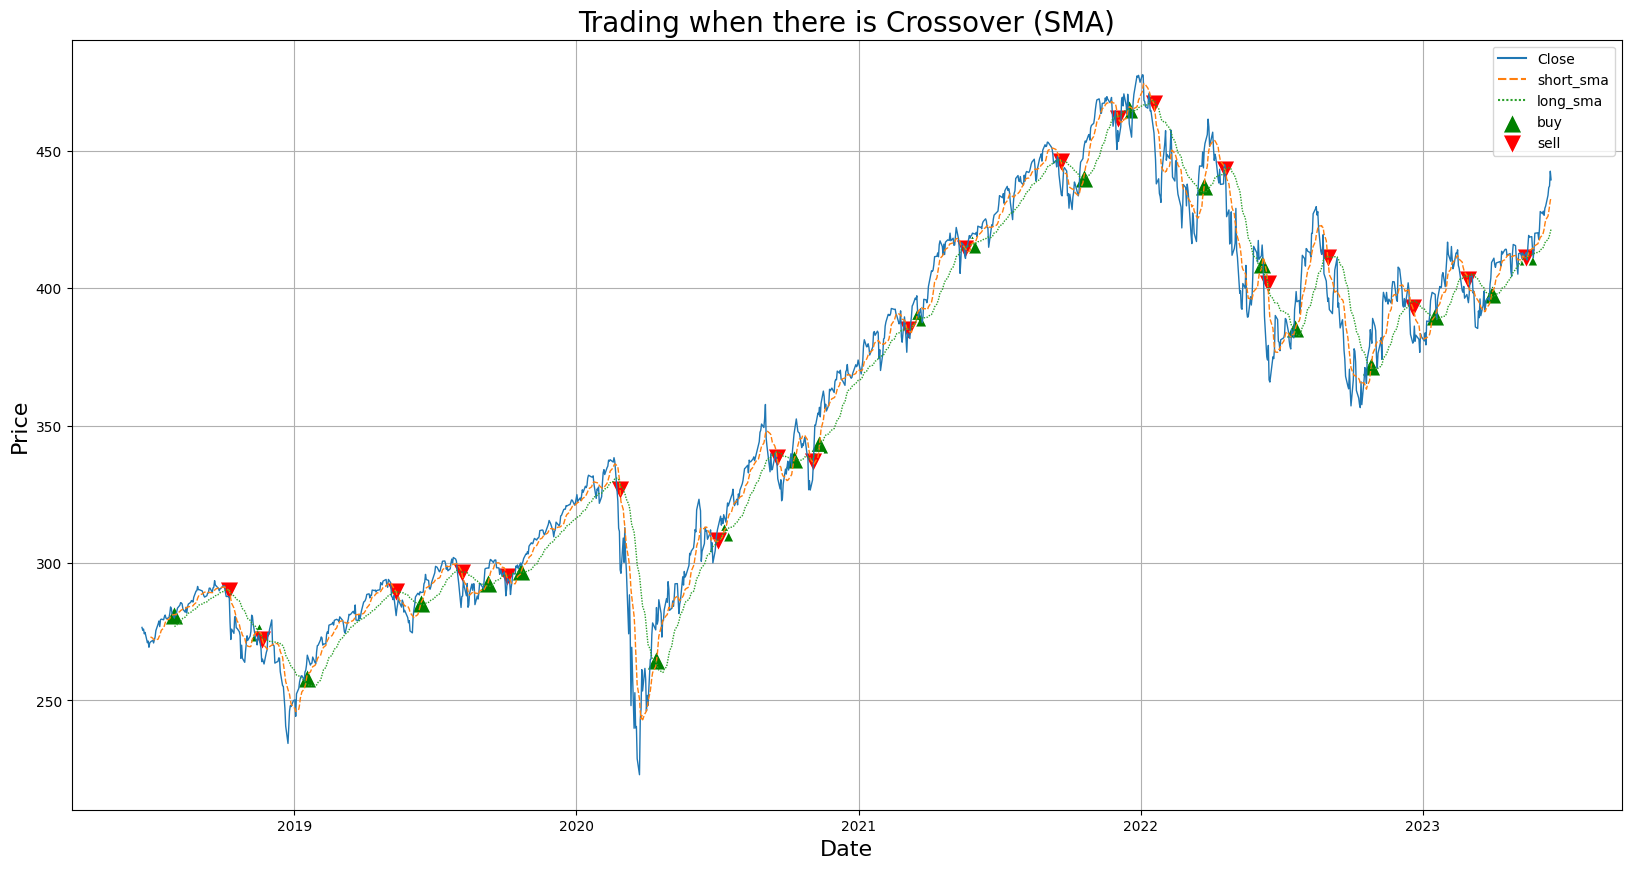

In [85]:
# Visualize SMA and EMA strategies with markers


# We will only look at positions where we rely on the information of the previous position e.g. if previous position is buy, and current
# position is buy, do not plot. But if position changes to sell, we want to see that marker displayed. 


import seaborn as sns
# I like seaborn plots better

plt.figure(figsize=(20, 10))
sns.lineplot(data=df[['Close', 'short_sma', 'long_sma']], lw=1)

buy_times = []
buy_dates = []
buy_values = []
sell_times = []
sell_dates = []
sell_values = []

prev_position = 0

for index, row in df.iterrows():
    position = row['Position_SMA']
    Date = row['DateTime']
    
    if position != prev_position:
        if position == 1:
            buy_times.append(index)
            buy_dates.append(Date)
            buy_values.append(row['short_sma'])
        elif position == -1:
            sell_times.append(index)
            sell_values.append(row['short_sma'])
            sell_dates.append(Date)
            
        
    prev_position = position

sns.scatterplot(x=buy_times, y=buy_values, marker='^', s=200, color='g', label='buy')
sns.scatterplot(x=sell_times, y=sell_values, marker='v', s=200, color='r', label='sell')

plt.ylabel('Price', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.title('Trading when there is Crossover (SMA)', fontsize=20)
plt.legend()
plt.grid()
plt.show()


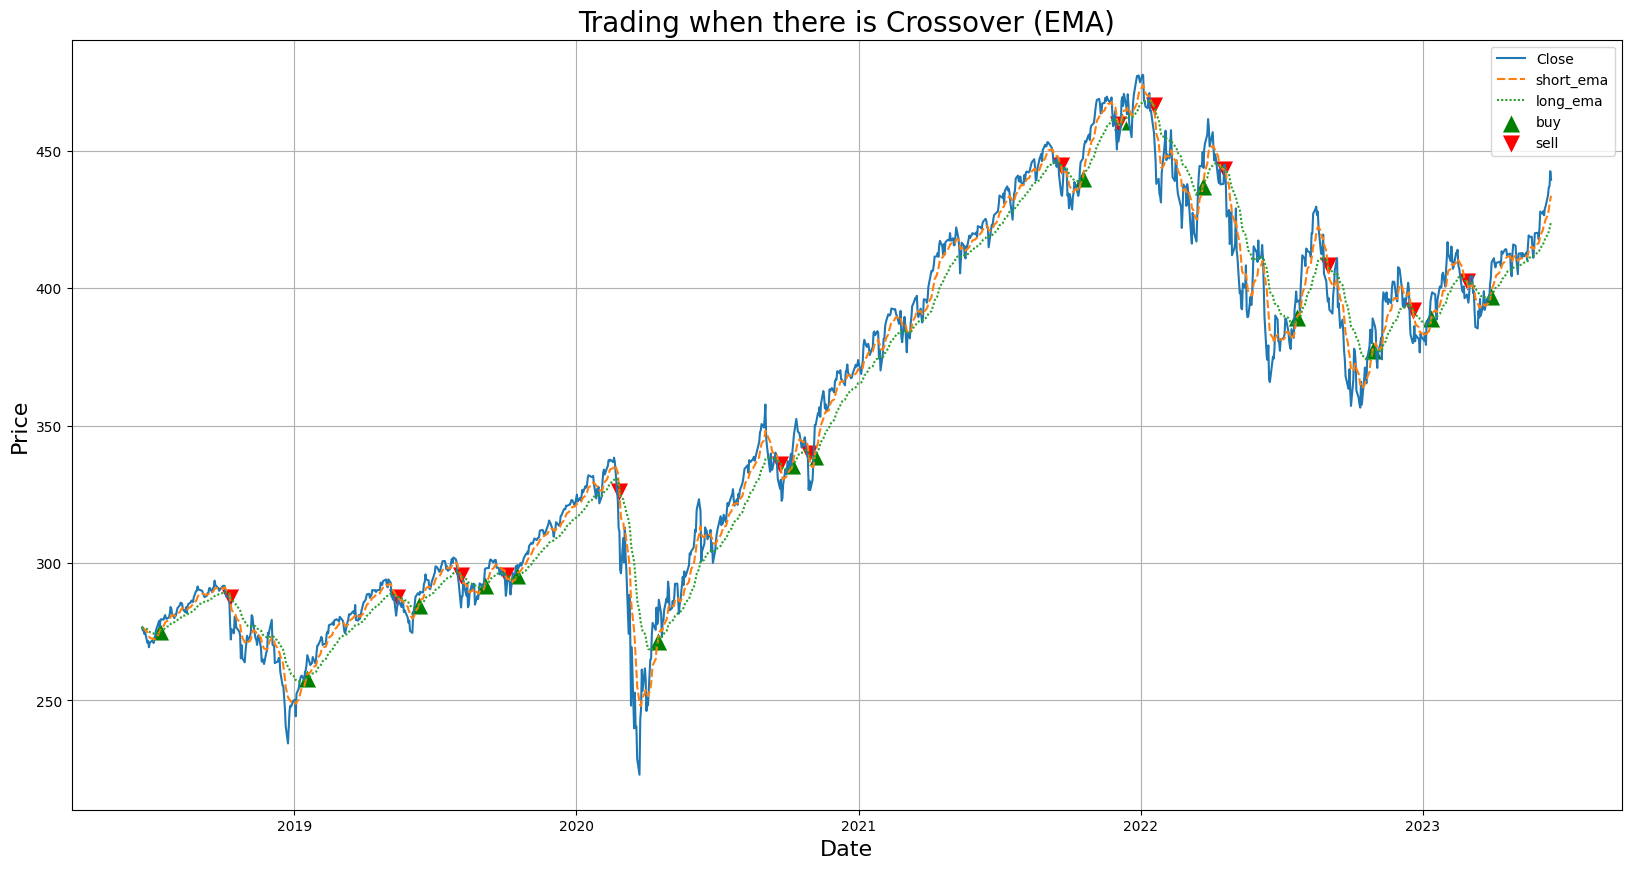

In [86]:
# Plot EMA

plt.figure(figsize=(20, 10))
sns.lineplot(data=df[['Close', 'short_ema', 'long_ema']],)

buy_times_EMA = []
buy_dates_EMA = []
buy_values_EMA = []
sell_times_EMA = []
sell_dates_EMA = []
sell_values_EMA = []

prev_position_EMA = 0

for i, row in df.iterrows():
    position_ema = row['Position_EMA']
    Date = row['DateTime']
    
    if position_ema != prev_position_EMA:
        if position_ema == 1:
            buy_times_EMA.append(i)
            buy_dates_EMA.append(Date)
            buy_values_EMA.append(row['short_ema'])
        elif position_ema == -1:
            sell_times_EMA.append(i)
            sell_dates_EMA.append(Date)
            sell_values_EMA.append(row['short_ema'])
            
        
    prev_position_EMA = position_ema

sns.scatterplot(x=buy_times_EMA, y=buy_values_EMA, marker='^', s=200, color='g', label='buy')
sns.scatterplot(x=sell_times_EMA, y=sell_values_EMA, marker='v', s=200, color='r', label='sell')

plt.ylabel('Price', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.title('Trading when there is Crossover (EMA)', fontsize=20)
plt.legend()
plt.grid()
plt.show()


In [87]:
# Lets figure out daily returns: for the underlying asset and then our strategies thus far

# Calculate Daily Returns
df['daily_returns_SPY'] = df['Close'].pct_change()
df

,DateTime,Open,High,Low,Close,short_sma,long_sma,short_ema,long_ema,sma_signal,ema_signal,Position_SMA,Position_EMA,daily_returns_SPY
Date,,,,,,,,,,,,,,
2018-06-18,2018-06-18,275.49,276.70,274.95,276.56,NaN,NaN,276.560000,276.560000,0,0,NaN,NaN,NaN
2018-06-19,2018-06-19,274.00,275.75,273.53,275.50,NaN,NaN,276.367273,276.491613,0,0,0.0,0.0,-0.003833
2018-06-20,2018-06-20,276.27,276.72,275.59,275.97,NaN,NaN,276.295041,276.457960,0,0,0.0,0.0,0.001706
2018-06-21,2018-06-21,275.96,275.98,273.68,274.24,NaN,NaN,275.921397,276.314866,0,0,0.0,0.0,-0.006269
2018-06-22,2018-06-22,275.66,275.79,274.49,274.74,NaN,NaN,275.706598,276.213262,0,0,0.0,0.0,0.001823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-12,2023-06-12,430.92,433.88,430.17,433.80,426.228,417.654333,426.690969,419.520959,1,1,0.0,0.0,0.009072
2023-06-13,2023-06-13,435.32,437.33,434.63,436.66,427.876,418.359333,428.503520,420.626703,1,1,0.0,0.0,0.006593
2023-06-14,2023-06-14,437.01,439.07,433.59,437.18,429.809,419.237333,430.081062,421.694658,1,1,0.0,0.0,0.001191


In [94]:
# Calculate strategy returns
df['sma_strategy_returns'] = df['daily_returns_SPY'] * df['Position_SMA'].shift()
df['ema_strategy_returns'] = df['daily_returns_SPY'] * df['Position_EMA'].shift()
df

,DateTime,Open,High,Low,Close,short_sma,long_sma,short_ema,long_ema,sma_signal,ema_signal,Position_SMA,Position_EMA,daily_returns_SPY,sma_strategy_returns,ema_strategy_returns
Date,,,,,,,,,,,,,,,,
2018-06-18,2018-06-18,275.49,276.70,274.95,276.56,NaN,NaN,276.560000,276.560000,0,0,NaN,NaN,NaN,NaN,NaN
2018-06-19,2018-06-19,274.00,275.75,273.53,275.50,NaN,NaN,276.367273,276.491613,0,0,0.0,0.0,-0.003833,NaN,NaN
2018-06-20,2018-06-20,276.27,276.72,275.59,275.97,NaN,NaN,276.295041,276.457960,0,0,0.0,0.0,0.001706,0.0,0.0
2018-06-21,2018-06-21,275.96,275.98,273.68,274.24,NaN,NaN,275.921397,276.314866,0,0,0.0,0.0,-0.006269,-0.0,-0.0
2018-06-22,2018-06-22,275.66,275.79,274.49,274.74,NaN,NaN,275.706598,276.213262,0,0,0.0,0.0,0.001823,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-12,2023-06-12,430.92,433.88,430.17,433.80,426.228,417.654333,426.690969,419.520959,1,1,0.0,0.0,0.009072,0.0,0.0
2023-06-13,2023-06-13,435.32,437.33,434.63,436.66,427.876,418.359333,428.503520,420.626703,1,1,0.0,0.0,0.006593,0.0,0.0
2023-06-14,2023-06-14,437.01,439.07,433.59,437.18,429.809,419.237333,430.081062,421.694658,1,1,0.0,0.0,0.001191,0.0,0.0


In [106]:
# Calculate PnLs for both strategies

df['sma_Cumulative_PnL'] = df['sma_strategy_returns'].cumsum()

df['ema_Cumulative_PnL'] = df['ema_strategy_returns'].cumsum()


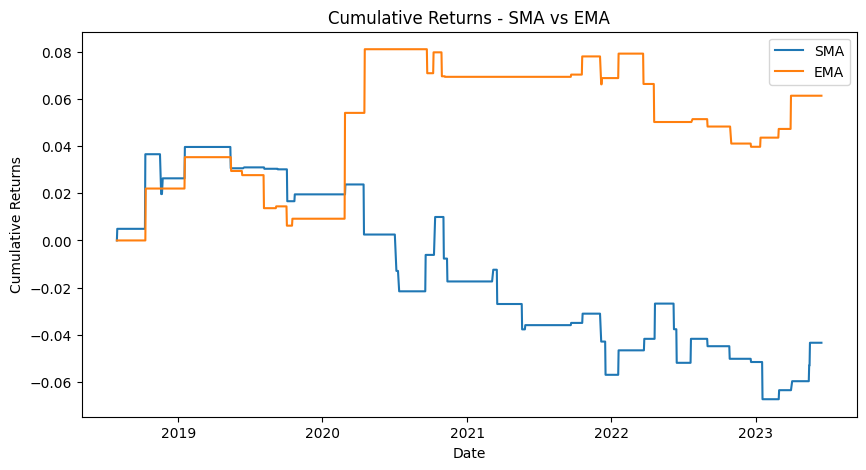

In [108]:
# Plot cumulative returns
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['sma_Cumulative_PnL'], label='SMA')
plt.plot(df.index, df['ema_Cumulative_PnL'], label='EMA')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns - SMA vs EMA')
plt.legend()
plt.grid(False)
plt.show()

# Note: We can see very clearly here were we are making a trade and when we are holding as those are the flat periods

In [226]:
#Now we can start implementing the ML strategies
#Drop the NaN values since Decision Tree Classifier cannot handle NaN. RF can but with very few NaN
#Imputation should not be necessary 

nan_count = df.isna().sum()

df.dropna(inplace=True)


In [197]:
# Prepare data for machine learning
# Recall: we are trying to figure out, as price moves on a day-to-day basis, 
# Can a learner predict when to buy and sell based on the historical crossover points.

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df[['short_sma', 'long_sma', 'short_ema', 'long_ema']]  # feature dataframe
y = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)  # target values i.e. (1) when next days close is greater than todays


#Now the short and long SMA and EMA strategies serve as features

,short_sma,long_sma,short_ema,long_ema
Date,,,,
2018-07-30,281.174,276.870667,280.794604,278.429193
2018-07-31,281.260,277.029667,280.891949,278.616342
2018-08-01,281.240,277.208333,280.886140,278.761094
2018-08-02,281.479,277.422333,281.159569,278.995217
2018-08-03,281.871,277.734333,281.603284,279.292300
...,...,...,...,...
2023-06-12,426.228,417.654333,426.690969,419.520959
2023-06-13,427.876,418.359333,428.503520,420.626703
2023-06-14,429.809,419.237333,430.081062,421.694658


In [214]:
# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#80-20 split

# Create a decision tree classifier and fit it to the training data
clf_DT = DecisionTreeClassifier()
clf_DT.fit(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create Random Forest Classifier (This is going to Overfit)
# clf_RF = RandomForestClassifier()
# clf_RF.fit(X_train, y_train)

# Predict the signals
df['ml_signal'] = clf_DT.predict(X)

# #Predict the signals
# df['RF_signal'] = clf_RF.predict(X)

signal_counts_ml = df['ml_signal'].value_counts()
signal_counts_ml



1    668
0    562
Name: ml_signal, dtype: int64

In [216]:
# ML strategy positions

df['Position_ML'] = df['ml_signal'].diff()

pos_counts_ml = df['Position_ML'].value_counts()
pos_counts_ml

 0.0    714
-1.0    258
 1.0    257
Name: Position_ML, dtype: int64

In [219]:
# Calculate the strategy returns for the ML strategy
df['ml_strategy_returns'] = df['daily_returns_SPY'] * df['Position_ML'].shift()

# #RF strat
# df['RF_strategy_returns'] = df['daily_returns_SPY'] * df['RF_signal'].shift()



In [227]:
# Cumalitive returns
df['ml_cumulative_returns'] = (df['ml_strategy_returns']).cumsum()
# df['RF_cumulative_returns'] = (df['RF_strategy_returns'] + 1).cumsum()


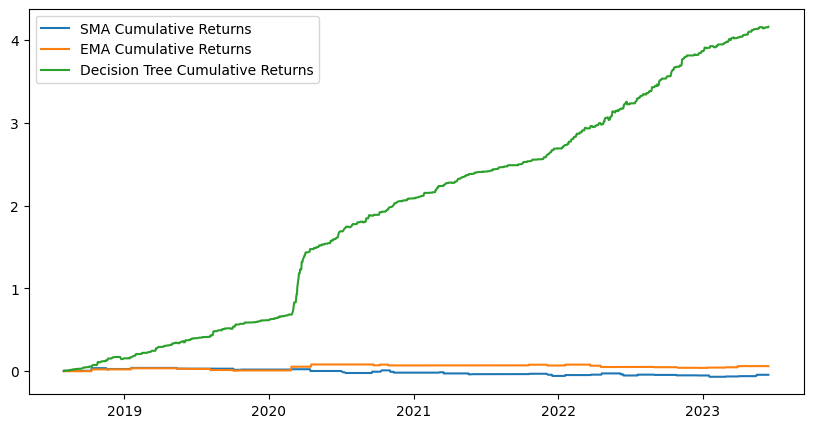

In [229]:
# Plotting the strategies
plt.figure(figsize=(10,5))
plt.plot(df['sma_Cumulative_PnL'], label='SMA Cumulative Returns')
plt.plot(df['ema_Cumulative_PnL'], label='EMA Cumulative Returns')
plt.plot(df['ml_cumulative_returns'], label='Decision Tree Cumulative Returns')
# plt.plot(df['RF_cumulative_returns'], label='RF Cumulative Returns')
plt.legend()
plt.show()


In [231]:
##Compare methods

# Calculate the Sharpe Ratio for each strategy
risk_free_rate = 0.0401 #July 10th, 2023 10-Y Treasury 
sma_excess_returns = df['sma_strategy_returns'] - risk_free_rate/252
ema_excess_returns = df['ema_strategy_returns'] - risk_free_rate/252
ml_excess_returns = df['ml_strategy_returns'] - risk_free_rate/252
# RF_excess_returns = df['RF_cumulative_returns'] - risk_free_rate/252


sma_sharpe_ratio = np.sqrt(252) * sma_excess_returns.mean() / sma_excess_returns.std()
ema_sharpe_ratio = np.sqrt(252) * ema_excess_returns.mean() / ema_excess_returns.std()
ml_sharpe_ratio = np.sqrt(252) * ml_excess_returns.mean() / ml_excess_returns.std()
# RF_sharpe_ratio = np.sqrt(252) * RF_excess_returns.mean() / RF_excess_returns.std()


# Create a DataFrame for the Sharpe Ratios
sharpe_data = {'Strategy': ['SMA', 'EMA', 'DecisionTree'], 'Sharpe Ratio': [sma_sharpe_ratio, 
                                                                                 ema_sharpe_ratio, 
                                                                                 ml_sharpe_ratio]}
sharpe_df = pd.DataFrame(sharpe_data)

print(sharpe_df)



       Strategy  Sharpe Ratio
0           SMA     -1.499822
1           EMA     -0.854915
2  DecisionTree      5.846525


In [232]:
%%latex

Brief Note here: So the RF algorithm overfits as is evident from the sharpe ratio test (It was around 27). Now we could adjust
    hyper-parameters but the reality is that this data-set is too small. So the RF classifier is memorizing
    the noise (or the idiosyncrasies of the training data) instead of learning patterns. 


<IPython.core.display.Latex object>

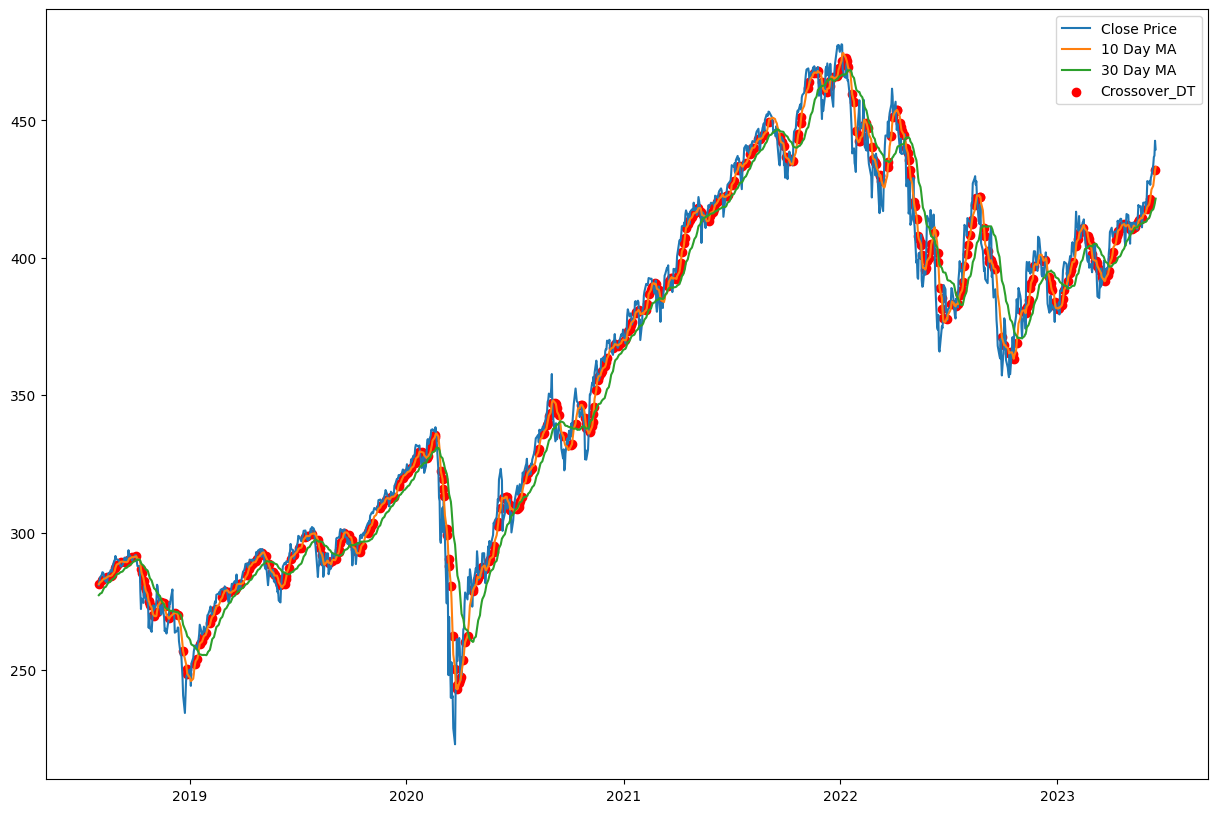

In [234]:
# lets see where the DT crossover points are ... marked in red dots

df['Crossover_DT'] = df['ml_signal'].diff().ne(0)

 
# Plot Close price, moving averages and the crossovers from Decision Tree
plt.figure(figsize=(15, 10))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['short_sma'], label='10 Day MA')
plt.plot(df['long_sma'], label='30 Day MA')
plt.scatter(df[df['Crossover_DT']].index, df['short_sma'][df['Crossover_DT']], color='red', marker='o', label='Crossover_DT')
plt.legend()
plt.show()

# Note a lot more transactions are occuring as the Decision Tree Classifier is able to
# Pick up more of the movent of the underlying price. In a real situation, I think one has to consider
# Transaction Costs for this many transactions. 




In [235]:
# PnL Exports
# Calculate the daily Marked-to-Market PnL for each strategy
df['sma_daily_pnl'] = df['sma_strategy_returns'] * df['Close']
df['ema_daily_pnl'] = df['ema_strategy_returns'] * df['Close']
df['ml_daily_pnl'] = df['ml_strategy_returns'] * df['Close']
# df['RF_daily_pnl'] = df['RF_strategy_returns'] * df['Close']


# # Export the daily Marked-to-Market PnL for each strategy to separate CSV files
# df[['DateTime', 'sma_daily_pnl']].to_csv('sma_daily_pnl.csv', index=False)
df[['DateTime', 'ema_daily_pnl']].to_csv('ema_daily_pnl.csv', index=False)
df[['DateTime', 'ml_daily_pnl']].to_csv('ml_daily_pnl.csv', index=False)

